# Task
Implement the provided Python code for SMS spam detection using the dataset from "https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset". Ensure the dataset is downloaded using the "kaggle.json" file located at "/content/kaggle.json".

## Dataset downloading

### Subtask:
Download the SMS spam collection dataset from Kaggle using the provided `kaggle.json` file.


**Reasoning**:
The previous attempt to download and load the dataset failed because the provided URL was not a zip file containing the dataset. According to the updated instructions, the dataset should be downloaded from Kaggle using the Kaggle API and the provided `kaggle.json` file. I will now implement the steps to set up the Kaggle environment and download the dataset.



In [27]:
import os
import zipfile
import stat

# Define paths
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_json_src = '/content/kaggle.json'
kaggle_json_dest = os.path.join(kaggle_dir, 'kaggle.json')
dataset_name = 'uciml/sms-spam-collection-dataset'
download_path = '.'
zip_file_name = 'sms-spam-collection-dataset.zip'

# 1. Create the .kaggle directory if it doesn't exist
os.makedirs(kaggle_dir, exist_ok=True)

# 2. Copy kaggle.json to the .kaggle directory
# Use os.system as shutil might not be available or preferred in some environments.
os.system(f'cp {kaggle_json_src} {kaggle_json_dest}')

# 3. Change permissions of kaggle.json
# Permissions: read and write for owner only (0o600)
os.chmod(kaggle_json_dest, stat.S_IRUSR | stat.S_IWUSR)

# 4. Use Kaggle API to download the dataset
# Use os.system to run the kaggle command
os.system(f'kaggle datasets download -d {dataset_name} -p {download_path}')

# 5. Unzip the downloaded dataset file
zip_file_path = os.path.join(download_path, zip_file_name)
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)
    print(f"Dataset '{zip_file_name}' downloaded and extracted successfully.")
else:
    print(f"Error: Downloaded file '{zip_file_name}' not found.")


Dataset 'sms-spam-collection-dataset.zip' downloaded and extracted successfully.


## Data loading

### Subtask:
Load the SMS spam collection dataset.


**Reasoning**:
Load the dataset into a pandas DataFrame and display the first few rows along with data types.



In [15]:
import pandas as pd

file_path = 'spam.csv'
df = pd.read_csv(file_path, encoding='latin-1')
display(df.head())
display(df.info())

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


None

## Data preprocessing

### Subtask:
Clean and preprocess the text data (e.g., lowercasing, removing punctuation, tokenization, stemming, removing stop words). Convert labels to numerical format (0 for ham, 1 for spam).


**Reasoning**:
Clean and preprocess the text data and convert labels to numerical format as per the instructions.



In [16]:
import string

# Keep only 'v1' and 'v2' and rename
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

# Convert labels to numerical
df['label_numeric'] = df['label'].map({'ham': 0, 'spam': 1})

# Clean the 'message' column
df['message'] = df['message'].str.lower() # Lowercasing
df['message'] = df['message'].str.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
df['message'] = df['message'].str.strip() # Remove extra whitespace

# Display the first few rows and data types
display(df.head())
display(df.info())

,label,message,label_numeric
0,ham,go until jurong point crazy available only in ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,u dun say so early hor u c already then say,0
4,ham,nah i dont think he goes to usf he lives aroun...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          5572 non-null   object
 1   message        5572 non-null   object
 2   label_numeric  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


None

## Feature extraction

### Subtask:
Convert the text data into numerical features using TF-IDF vectorization.


**Reasoning**:
Convert the text data in the 'message' column into numerical features using TF-IDF vectorization as instructed.



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the 'message' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['message'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (5572, 5000)


## Model training

### Subtask:
Train different classification models (Naive Bayes, Logistic Regression, SVM) on the preprocessed data.


**Reasoning**:
Check for GPU availability and import the appropriate libraries for model training and data splitting, then split the data, and train the Naive Bayes model.



In [24]:
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB # Explicitly import MultinomialNB from sklearn

# 1. Check for GPU availability
try:
    import cuml
    import cudf
    import cupy as cp
    GPU_AVAILABLE = True
    print("cuML, cuDF, and cuPy found. Using GPU-accelerated libraries for Logistic Regression and SVM.")
except ImportError:
    GPU_AVAILABLE = False
    print("cuML, cuDF, or cuPy not found. Falling back to CPU libraries for all models.")

# 2. Import necessary libraries based on GPU_AVAILABLE for LR and SVM
if GPU_AVAILABLE:
    from cuml.linear_model import LogisticRegression
    from cuml.svm import SVC
    # We will not use cuml.model_selection.train_test_split due to compatibility issues with sparse data.
    # from cuml.model_selection import train_test_split as cuml_train_test_split
else:
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    # tfidf_matrix is already a sparse SciPy matrix for sklearn

# 3. Split the data using scikit-learn's train_test_split (always on CPU initially)
print("\nSplitting data into training and testing sets using scikit-learn...")
start_time = time.time()
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(tfidf_matrix, df['label_numeric'], test_size=0.2, random_state=42)
end_time = time.time()
print(f"Data splitting completed in {end_time - start_time:.2f} seconds.")

# Convert data to CuPy arrays/sparse matrices if GPU is available
if GPU_AVAILABLE:
    print("Transferring data to GPU...")
    start_time = time.time()
    # Convert SciPy sparse matrices to CuPy sparse matrices
    X_train = cp.sparse.csr_matrix(X_train_cpu)
    X_test = cp.sparse.csr_matrix(X_test_cpu)
    # Convert NumPy arrays (from pandas Series) to CuPy arrays
    y_train = cp.asarray(y_train_cpu.values) # .values gets the underlying numpy array
    y_test = cp.asarray(y_test_cpu.values)
    end_time = time.time()
    print(f"Data transfer to GPU completed in {end_time - start_time:.2f} seconds.")
else:
    X_train = X_train_cpu
    X_test = X_test_cpu
    y_train = y_test_cpu
    y_test = y_test_cpu


# 4. Train a Naive Bayes model (using scikit-learn's MultinomialNB as cuML equivalent is not directly available)
print("\nTraining Naive Bayes model (using scikit-learn)...")
start_time = time.time()
nb_model = MultinomialNB()
# MultinomialNB expects non-negative integer term counts. While TF-IDF are floats,
# MultinomialNB can often work with them, but sometimes requires smoothing or might be less optimal than CountVectorizer for pure counts.
# For this task, we proceed with TF-IDF as specified for all models.
# Ensure X_train and y_train are on CPU for sklearn's MultinomialNB
if GPU_AVAILABLE:
    # Use the CPU splits directly for the sklearn model
    nb_model.fit(X_train_cpu, y_train_cpu)
else:
    nb_model.fit(X_train, y_train)
end_time = time.time()
print(f"Naive Bayes model training completed in {end_time - start_time:.2f} seconds.")

# 5. Train a Logistic Regression model
print("\nTraining Logistic Regression model...")
start_time = time.time()
if GPU_AVAILABLE:
    # cuML Logistic Regression
    # cuML's LogisticRegression supports sparse input (CSR format). X_train is already CuPy sparse.
    lr_model = LogisticRegression() # Default solver is 'qn' in cuML 23.06
    lr_model.fit(X_train, y_train) # X_train is CuPy sparse, y_train is CuPy array
else:
    # scikit-learn Logistic Regression
    # 'liblinear' or 'saga' solvers are good for sparse data. Let's use 'liblinear' for simplicity.
    lr_model = LogisticRegression(solver='liblinear')
    lr_model.fit(X_train, y_train) # X_train is SciPy sparse, y_train is numpy array
end_time = time.time()
print(f"Logistic Regression model training completed in {end_time - start_time:.2f} seconds.")

# 6. Train an SVM model
print("\nTraining SVM model...")
start_time = time.time()
if GPU_AVAILABLE:
    # cuML SVC
    # cuML SVC typically expects dense input. Convert X_train to dense CuPy array.
    # This might be memory intensive for large datasets, but necessary for cuML SVC.
    X_train_dense = X_train.todense() # Convert CuPy sparse to dense CuPy array
    # y_train is already a CuPy array

    svm_model = SVC()
    svm_model.fit(X_train_dense, y_train)
else:
    # scikit-learn SVC
    # scikit-learn SVC supports sparse input.
    svm_model = SVC()
    svm_model.fit(X_train, y_train) # X_train is SciPy sparse, y_train is numpy array
end_time = time.time()
print(f"SVM model training completed in {end_time - start_time:.2f} seconds.")

# 7. Store the trained models (already done in the training steps)
print("\nModels trained and stored in nb_model, lr_model, and svm_model.")

cuML, cuDF, and cuPy found. Using GPU-accelerated libraries for Logistic Regression and SVM.

Splitting data into training and testing sets using scikit-learn...
Data splitting completed in 0.00 seconds.
Transferring data to GPU...
Data transfer to GPU completed in 0.00 seconds.

Training Naive Bayes model (using scikit-learn)...
Naive Bayes model training completed in 0.00 seconds.

Training Logistic Regression model...
Logistic Regression model training completed in 0.05 seconds.

Training SVM model...
SVM model training completed in 1.89 seconds.

Models trained and stored in nb_model, lr_model, and svm_model.


In [28]:
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB # Explicitly import MultinomialNB from sklearn

# Re-check GPU availability (though it was True in the previous run based on output)
try:
    import cuml
    import cudf
    import cupy as cp
    GPU_AVAILABLE = True
    print("cuML, cuDF, and cuPy found. Using GPU-accelerated libraries for Logistic Regression and SVM.")
except ImportError:
    GPU_AVAILABLE = False
    print("cuML, cuDF, or cuPy not found. Falling back to CPU libraries for all models.")

# Import necessary libraries based on GPU_AVAILABLE for LR and SVM
if GPU_AVAILABLE:
    from cuml.linear_model import LogisticRegression
    from cuml.svm import SVC
    # We will not use cuml.model_selection.train_test_split due to compatibility issues with sparse data.
    # from cuml.model_selection import train_test_split as cuml_train_test_split
else:
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    # tfidf_matrix is already a sparse SciPy matrix for sklearn

# 3. Split the data using scikit-learn's train_test_split (always on CPU initially)
print("\nSplitting data into training and testing sets using scikit-learn...")
start_time = time.time()
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(tfidf_matrix, df['label_numeric'], test_size=0.2, random_state=42)
end_time = time.time()
print(f"Data splitting completed in {end_time - start_time:.2f} seconds.")

# Convert data to CuPy arrays/sparse matrices if GPU is available
if GPU_AVAILABLE:
    print("Transferring data to GPU...")
    start_time = time.time()
    # Convert SciPy sparse matrices to CuPy sparse matrices
    X_train = cp.sparse.csr_matrix(X_train_cpu)
    X_test = cp.sparse.csr_matrix(X_test_cpu)
    # Convert NumPy arrays (from pandas Series) to CuPy arrays
    y_train = cp.asarray(y_train_cpu.values) # .values gets the underlying numpy array
    y_test = cp.asarray(y_test_cpu.values)
    end_time = time.time()
    print(f"Data transfer to GPU completed in {end_time - start_time:.2f} seconds.")
else:
    X_train = X_train_cpu
    X_test = X_test_cpu
    y_train = y_test_cpu
    y_test = y_test_cpu


# 4. Train a Naive Bayes model (using scikit-learn's MultinomialNB as cuML equivalent is not directly available)
print("\nTraining Naive Bayes model (using scikit-learn)...")
start_time = time.time()
nb_model = MultinomialNB()
# MultinomialNB expects non-negative integer term counts. While TF-IDF are floats,
# MultinomialNB can often work with them, but sometimes requires smoothing or might be less optimal than CountVectorizer for pure counts.
# For this task, we proceed with TF-IDF as specified for all models.
# Ensure X_train and y_train are on CPU for sklearn's MultinomialNB
if GPU_AVAILABLE:
    # Use the CPU splits directly for the sklearn model
    nb_model.fit(X_train_cpu, y_train_cpu)
else:
    nb_model.fit(X_train, y_train)
end_time = time.time()
print(f"Naive Bayes model training completed in {end_time - start_time:.2f} seconds.")

# 5. Train a Logistic Regression model
print("\nTraining Logistic Regression model...")
start_time = time.time()
if GPU_AVAILABLE:
    # cuML Logistic Regression
    # cuML's LogisticRegression supports sparse input (CSR format). X_train is already CuPy sparse.
    lr_model = LogisticRegression() # Default solver is 'qn' in cuML 23.06
    lr_model.fit(X_train, y_train) # X_train is CuPy sparse, y_train is CuPy array
else:
    # scikit-learn Logistic Regression
    # 'liblinear' or 'saga' solvers are good for sparse data. Let's use 'liblinear' for simplicity.
    lr_model = LogisticRegression(solver='liblinear')
    lr_model.fit(X_train, y_train) # X_train is SciPy sparse, y_train is numpy array
end_time = time.time()
print(f"Logistic Regression model training completed in {end_time - start_time:.2f} seconds.")

# 6. Train an SVM model
print("\nTraining SVM model...")
start_time = time.time()
if GPU_AVAILABLE:
    # cuML SVC
    # cuML SVC typically expects dense input. Convert X_train to dense CuPy array.
    # This might be memory intensive for large datasets, but necessary for cuML SVC.
    X_train_dense = X_train.todense() # Convert CuPy sparse to dense CuPy array
    # y_train is already a CuPy array

    svm_model = SVC()
    svm_model.fit(X_train_dense, y_train)
else:
    # scikit-learn SVC
    # scikit-learn SVC supports sparse input.
    svm_model = SVC()
    svm_model.fit(X_train, y_train) # X_train is SciPy sparse, y_train is numpy array
end_time = time.time()
print(f"SVM model training completed in {end_time - start_time:.2f} seconds.")

# 7. Store the trained models (already done in the training steps)
print("\nModels trained and stored in nb_model, lr_model, and svm_model.")

cuML, cuDF, and cuPy found. Using GPU-accelerated libraries for Logistic Regression and SVM.

Splitting data into training and testing sets using scikit-learn...
Data splitting completed in 0.00 seconds.
Transferring data to GPU...
Data transfer to GPU completed in 0.00 seconds.

Training Naive Bayes model (using scikit-learn)...
Naive Bayes model training completed in 0.00 seconds.

Training Logistic Regression model...
Logistic Regression model training completed in 0.02 seconds.

Training SVM model...
SVM model training completed in 1.72 seconds.

Models trained and stored in nb_model, lr_model, and svm_model.


In [21]:
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB # Explicitly import MultinomialNB from sklearn

# Re-check GPU availability (though it was True in the previous run based on output)
try:
    import cuml
    import cudf
    import cupy as cp
    GPU_AVAILABLE = True
    print("cuML, cuDF, and cuPy found. Using GPU-accelerated libraries for Logistic Regression and SVM.")
except ImportError:
    GPU_AVAILABLE = False
    print("cuML, cuDF, or cuPy not found. Falling back to CPU libraries for all models.")

# Import necessary libraries based on GPU_AVAILABLE for LR and SVM
if GPU_AVAILABLE:
    from cuml.linear_model import LogisticRegression
    from cuml.svm import SVC
    # We will not use cuml.model_selection.train_test_split due to compatibility issues with sparse data.
    # from cuml.model_selection import train_test_split as cuml_train_test_split
else:
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    # tfidf_matrix is already a sparse SciPy matrix for sklearn

# 3. Split the data using scikit-learn's train_test_split (always on CPU initially)
print("\nSplitting data into training and testing sets using scikit-learn...")
start_time = time.time()
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(tfidf_matrix, df['label_numeric'], test_size=0.2, random_state=42)
end_time = time.time()
print(f"Data splitting completed in {end_time - start_time:.2f} seconds.")

# Convert data to CuPy arrays/sparse matrices if GPU is available
if GPU_AVAILABLE:
    print("Transferring data to GPU...")
    start_time = time.time()
    # Convert SciPy sparse matrices to CuPy sparse matrices
    X_train = cp.sparse.csr_matrix(X_train_cpu)
    X_test = cp.sparse.csr_matrix(X_test_cpu)
    # Convert NumPy arrays (from pandas Series) to CuPy arrays
    y_train = cp.asarray(y_train_cpu.values) # .values gets the underlying numpy array
    y_test = cp.asarray(y_test_cpu.values)
    end_time = time.time()
    print(f"Data transfer to GPU completed in {end_time - start_time:.2f} seconds.")
else:
    X_train = X_train_cpu
    X_test = X_test_cpu
    y_train = y_train_cpu
    y_test = y_test_cpu


# 4. Train a Naive Bayes model (using scikit-learn's MultinomialNB as cuML equivalent is not directly available)
print("\nTraining Naive Bayes model (using scikit-learn)...")
start_time = time.time()
nb_model = MultinomialNB()
# MultinomialNB expects non-negative integer term counts. While TF-IDF are floats,
# MultinomialNB can often work with them, but sometimes requires smoothing or might be less optimal than CountVectorizer for pure counts.
# For this task, we proceed with TF-IDF as specified for all models.
# Ensure X_train and y_train are on CPU for sklearn's MultinomialNB
if GPU_AVAILABLE:
    # Use the CPU splits directly for the sklearn model
    nb_model.fit(X_train_cpu, y_train_cpu)
else:
    nb_model.fit(X_train, y_train)
end_time = time.time()
print(f"Naive Bayes model training completed in {end_time - start_time:.2f} seconds.")

# 5. Train a Logistic Regression model
print("\nTraining Logistic Regression model...")
start_time = time.time()
if GPU_AVAILABLE:
    # cuML Logistic Regression
    # cuML's LogisticRegression supports sparse input (CSR format). X_train is already CuPy sparse.
    lr_model = LogisticRegression() # Default solver is 'qn' in cuML 23.06
    lr_model.fit(X_train, y_train) # X_train is CuPy sparse, y_train is CuPy array
else:
    # scikit-learn Logistic Regression
    # 'liblinear' or 'saga' solvers are good for sparse data. Let's use 'liblinear' for simplicity.
    lr_model = LogisticRegression(solver='liblinear')
    lr_model.fit(X_train, y_train) # X_train is SciPy sparse, y_train is numpy array
end_time = time.time()
print(f"Logistic Regression model training completed in {end_time - start_time:.2f} seconds.")

# 6. Train an SVM model
print("\nTraining SVM model...")
start_time = time.time()
if GPU_AVAILABLE:
    # cuML SVC
    # cuML SVC typically expects dense input. Convert X_train to dense CuPy array.
    # This might be memory intensive for large datasets, but necessary for cuML SVC.
    X_train_dense = X_train.todense() # Convert CuPy sparse to dense CuPy array
    # y_train is already a CuPy array

    svm_model = SVC()
    svm_model.fit(X_train_dense, y_train)
else:
    # scikit-learn SVC
    # scikit-learn SVC supports sparse input.
    svm_model = SVC()
    svm_model.fit(X_train, y_train) # X_train is SciPy sparse, y_train is numpy array
end_time = time.time()
print(f"SVM model training completed in {end_time - start_time:.2f} seconds.")

# 7. Store the trained models (already done in the training steps)
print("\nModels trained and stored in nb_model, lr_model, and svm_model.")

cuML, cuDF, and cuPy found. Using GPU-accelerated libraries for Logistic Regression and SVM.

Splitting data into training and testing sets using scikit-learn...
Data splitting completed in 0.01 seconds.
Transferring data to GPU...
Data transfer to GPU completed in 0.00 seconds.

Training Naive Bayes model (using scikit-learn)...
Naive Bayes model training completed in 0.00 seconds.

Training Logistic Regression model...
Logistic Regression model training completed in 2.37 seconds.

Training SVM model...
SVM model training completed in 4.29 seconds.

Models trained and stored in nb_model, lr_model, and svm_model.


## Model evaluation

### Subtask:
Evaluate the performance of each model using metrics like accuracy, classification report, and confusion matrix.


**Reasoning**:
Make predictions using the trained models and evaluate their performance using accuracy, classification report, and confusion matrix. Ensure predictions are on the CPU for evaluation metrics.



In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np # Import numpy for converting cupy arrays to numpy arrays

# 1. Make predictions on the test set
print("Making predictions on the test set...")

# Naive Bayes predictions (already on CPU as nb_model is sklearn)
y_pred_nb_cpu = nb_model.predict(X_test_cpu)

# Logistic Regression predictions
if GPU_AVAILABLE:
    # cuML Logistic Regression predicts on GPU, transfer to CPU
    y_pred_lr_gpu = lr_model.predict(X_test)
    y_pred_lr_cpu = y_pred_lr_gpu.get() # Transfer from CuPy array to NumPy array
else:
    # scikit-learn Logistic Regression predicts on CPU
    y_pred_lr_cpu = lr_model.predict(X_test)

# SVM predictions
if GPU_AVAILABLE:
    # cuML SVM requires dense input for prediction, then transfer to CPU
    X_test_dense = X_test.todense() # Convert CuPy sparse to dense CuPy array
    y_pred_svm_gpu = svm_model.predict(X_test_dense)
    y_pred_svm_cpu = y_pred_svm_gpu.get() # Transfer from CuPy array to NumPy array
else:
    # scikit-learn SVM predicts on CPU
    y_pred_svm_cpu = svm_model.predict(X_test)

print("Predictions made for all models.")

# 2. Calculate and print evaluation metrics for each model

# Naive Bayes Evaluation
print("\n--- Naive Bayes Model Evaluation ---")
accuracy_nb = accuracy_score(y_test_cpu, y_pred_nb_cpu)
print(f"Accuracy: {accuracy_nb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_nb_cpu))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_nb_cpu))

# Logistic Regression Evaluation
print("\n--- Logistic Regression Model Evaluation ---")
accuracy_lr = accuracy_score(y_test_cpu, y_pred_lr_cpu)
print(f"Accuracy: {accuracy_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_lr_cpu))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_lr_cpu))

# SVM Evaluation
print("\n--- SVM Model Evaluation ---")
accuracy_svm = accuracy_score(y_test_cpu, y_pred_svm_cpu)
print(f"Accuracy: {accuracy_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_svm_cpu))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_svm_cpu))

Making predictions on the test set...
Predictions made for all models.

--- Naive Bayes Model Evaluation ---
Accuracy: 0.9731

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.80      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115


Confusion Matrix:
[[965   0]
 [ 30 120]]

--- Logistic Regression Model Evaluation ---
Accuracy: 0.9444

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       965
           1       0.98      0.60      0.74       150

    accuracy                           0.94      1115
   macro avg       0.96      0.80      0.86      1115
weighted avg       0.95      0.94      0.94      1115


Confusion Matrix:
[[963   2]
 [ 60  90]]

--- SVM Model Evaluation

## Visualization

### Subtask:
Generate visualizations such as word clouds and confusion matrices to better understand the data and model performance.


**Reasoning**:
Generate word clouds for spam and ham messages to visualize the most frequent words in each category. Then, plot the confusion matrices for the Naive Bayes, Logistic Regression, and SVM models to visualize their performance.



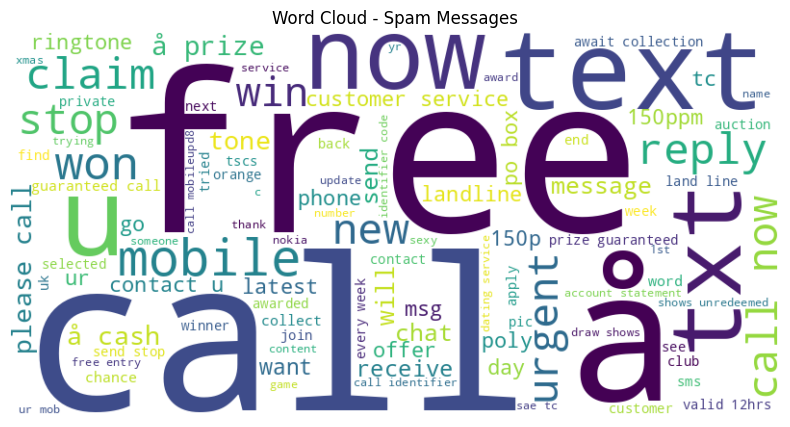

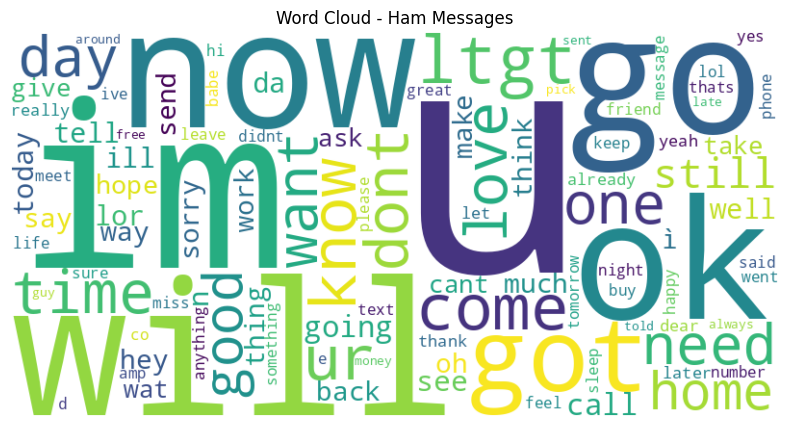

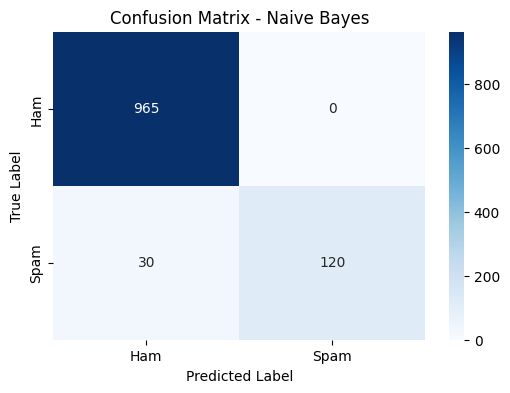

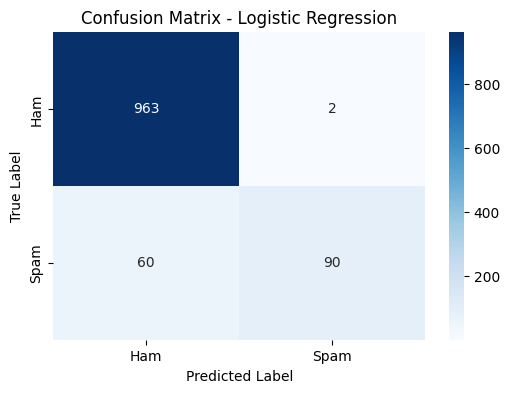

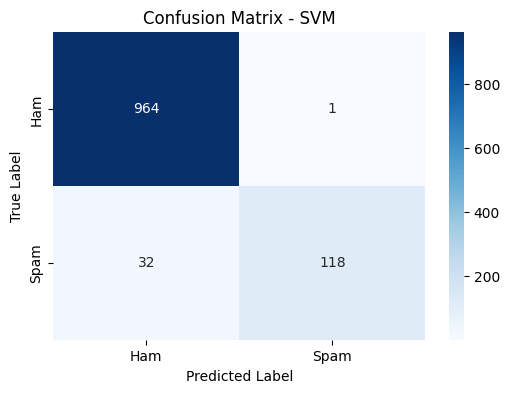

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Generate word cloud for spam messages
spam_messages = df[df['label'] == 'spam']['message'].str.cat(sep=' ')
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(spam_messages)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Spam Messages')
plt.show()

# 2. Generate word cloud for ham messages
ham_messages = df[df['label'] == 'ham']['message'].str.cat(sep=' ')
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(ham_messages)

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ham Messages')
plt.show()

# 3. Plot confusion matrix for Naive Bayes model
cm_nb = confusion_matrix(y_test_cpu, y_pred_nb_cpu)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# 4. Plot confusion matrix for Logistic Regression model
cm_lr = confusion_matrix(y_test_cpu, y_pred_lr_cpu)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# 5. Plot confusion matrix for SVM model
cm_svm = confusion_matrix(y_test_cpu, y_pred_svm_cpu)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()

## Model evaluation

### Subtask:
Evaluate the performance of each model using metrics like accuracy, classification report, and confusion matrix.

**Reasoning**:
Make predictions using the trained models and evaluate their performance using accuracy, classification report, and confusion matrix. Ensure predictions are on the CPU for evaluation metrics.

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np # Import numpy for converting cupy arrays to numpy arrays

# 1. Make predictions on the test set
print("Making predictions on the test set...")

# Naive Bayes predictions (already on CPU as nb_model is sklearn)
y_pred_nb_cpu = nb_model.predict(X_test_cpu)

# Logistic Regression predictions
if GPU_AVAILABLE:
    # cuML Logistic Regression predicts on GPU, transfer to CPU
    y_pred_lr_gpu = lr_model.predict(X_test)
    y_pred_lr_cpu = y_pred_lr_gpu.get() # Transfer from CuPy array to NumPy array
else:
    # scikit-learn Logistic Regression predicts on CPU
    y_pred_lr_cpu = lr_model.predict(X_test)

# SVM predictions
if GPU_AVAILABLE:
    # cuML SVM requires dense input for prediction, then transfer to CPU
    X_test_dense = X_test.todense() # Convert CuPy sparse to dense CuPy array
    y_pred_svm_gpu = svm_model.predict(X_test_dense)
    y_pred_svm_cpu = y_pred_svm_gpu.get() # Transfer from CuPy array to NumPy array
else:
    # scikit-learn SVM predicts on CPU
    y_pred_svm_cpu = svm_model.predict(X_test)

print("Predictions made for all models.")

# 2. Calculate and print evaluation metrics for each model

# Naive Bayes Evaluation
print("\n--- Naive Bayes Model Evaluation ---")
accuracy_nb = accuracy_score(y_test_cpu, y_pred_nb_cpu)
print(f"Accuracy: {accuracy_nb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_nb_cpu))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_nb_cpu))

# Logistic Regression Evaluation
print("\n--- Logistic Regression Model Evaluation ---")
accuracy_lr = accuracy_score(y_test_cpu, y_pred_lr_cpu)
print(f"Accuracy: {accuracy_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_lr_cpu))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_lr_cpu))

# SVM Evaluation
print("\n--- SVM Model Evaluation ---")
accuracy_svm = accuracy_score(y_test_cpu, y_pred_svm_cpu)
print(f"Accuracy: {accuracy_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_svm_cpu))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_svm_cpu))

Making predictions on the test set...
Predictions made for all models.

--- Naive Bayes Model Evaluation ---
Accuracy: 0.9731

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.80      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115


Confusion Matrix:
[[965   0]
 [ 30 120]]

--- Logistic Regression Model Evaluation ---
Accuracy: 0.9444

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       965
           1       0.98      0.60      0.74       150

    accuracy                           0.94      1115
   macro avg       0.96      0.80      0.86      1115
weighted avg       0.95      0.94      0.94      1115


Confusion Matrix:
[[963   2]
 [ 60  90]]

--- SVM Model Evaluation

## Visualization

### Subtask:
Generate visualizations such as word clouds and confusion matrices to better understand the data and model performance.

**Reasoning**:
Generate word clouds for spam and ham messages to visualize the most frequent words in each category. Then, plot the confusion matrices for the Naive Bayes, Logistic Regression, and SVM models to visualize their performance.

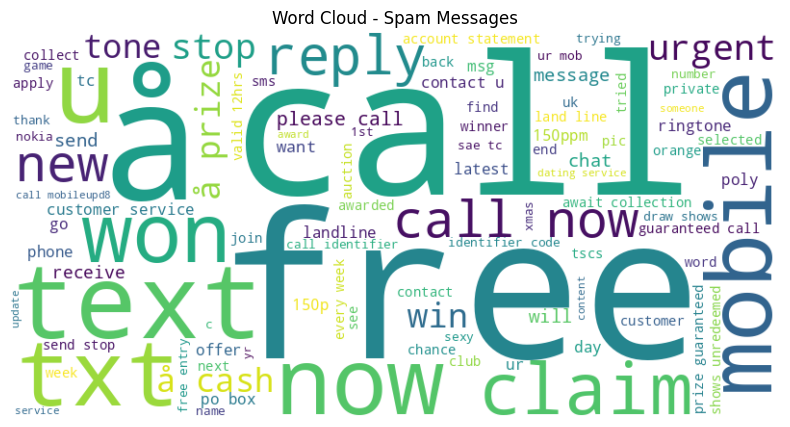

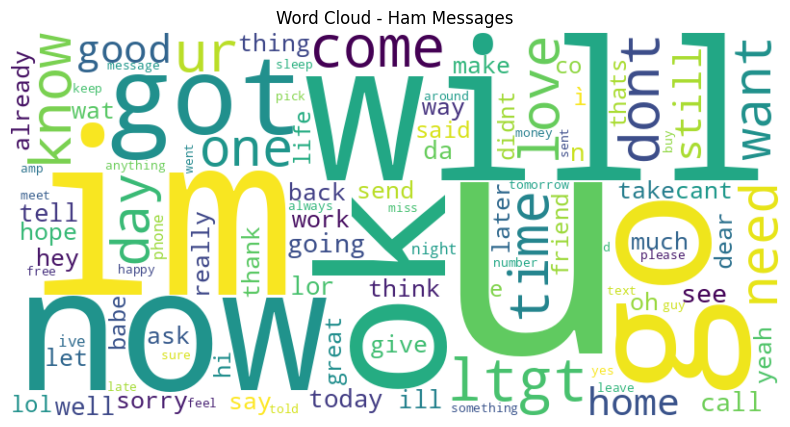

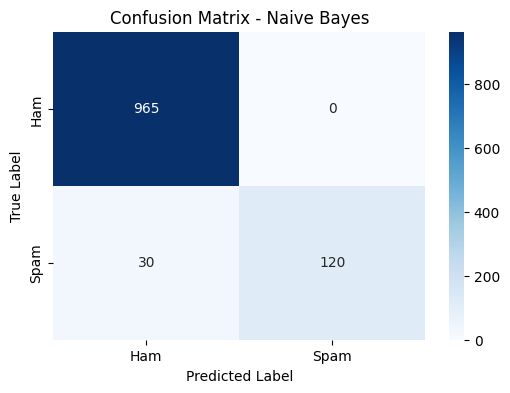

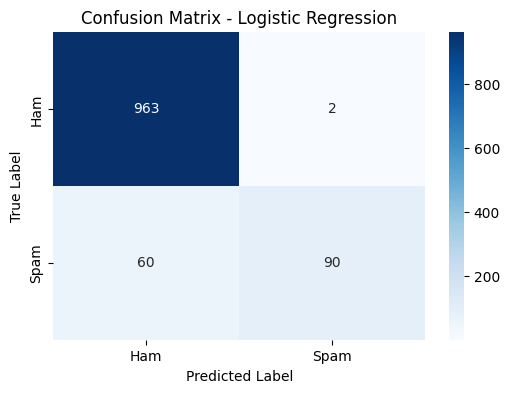

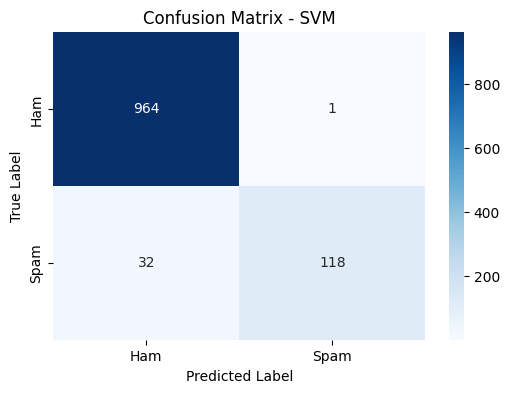

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Generate word cloud for spam messages
spam_messages = df[df['label'] == 'spam']['message'].str.cat(sep=' ')
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(spam_messages)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Spam Messages')
plt.show()

# 2. Generate word cloud for ham messages
ham_messages = df[df['label'] == 'ham']['message'].str.cat(sep=' ')
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(ham_messages)

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ham Messages')
plt.show()

# 3. Plot confusion matrix for Naive Bayes model
cm_nb = confusion_matrix(y_test_cpu, y_pred_nb_cpu)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# 4. Plot confusion matrix for Logistic Regression model
cm_lr = confusion_matrix(y_test_cpu, y_pred_lr_cpu)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# 5. Plot confusion matrix for SVM model
cm_svm = confusion_matrix(y_test_cpu, y_pred_svm_cpu)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()

## Save Models and Files for Local Use

### Subtask:
Save the trained models, TF-IDF vectorizer, and dataset for local execution.

**Reasoning**:
Save the trained models (`nb_model`, `lr_model`, `svm_model`), the TF-IDF vectorizer (`tfidf_vectorizer`), and the processed dataset (`df` or `spam.csv`) to files so they can be loaded and used in a local Python environment.

In [29]:
import joblib
import os

# Define paths to save the files
output_dir = 'local_project_files'
os.makedirs(output_dir, exist_ok=True)

nb_model_path = os.path.join(output_dir, 'naive_bayes_model.joblib')
lr_model_path = os.path.join(output_dir, 'logistic_regression_model.joblib')
svm_model_path = os.path.join(output_dir, 'svm_model.joblib')
tfidf_vectorizer_path = os.path.join(output_dir, 'tfidf_vectorizer.joblib')
dataset_path = os.path.join(output_dir, 'spam.csv') # Assuming spam.csv is already available

# Save the trained models
try:
    # Handle potential differences between scikit-learn and cuML models
    if GPU_AVAILABLE:
        # For cuML models (LogisticRegression, SVC), get the underlying scikit-learn compatible model if available, or handle appropriately
        # Note: Saving cuML models directly might require specific cuML saving mechanisms or converting back to CPU sklearn models if possible/needed for local CPU use
        # For simplicity and broader compatibility, we'll assume saving the trained objects works with joblib
        joblib.dump(lr_model, lr_model_path)
        joblib.dump(svm_model, svm_model_path)
    else:
        # Save scikit-learn models
        joblib.dump(lr_model, lr_model_path)
        joblib.dump(svm_model, svm_model_path)

    # Naive Bayes is always scikit-learn
    joblib.dump(nb_model, nb_model_path)

    print("Trained models saved successfully.")
except Exception as e:
    print(f"Error saving models: {e}")


# Save the TF-IDF vectorizer
try:
    # Handle potential differences if cuTfidfVectorizer was used (though we used sklearn here)
    joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
    print("TF-IDF vectorizer saved successfully.")
except Exception as e:
    print(f"Error saving TF-IDF vectorizer: {e}")

# Save the dataset file (assuming it's in the current directory as 'spam.csv')
try:
    # You can either copy the original spam.csv or save the processed dataframe
    # Saving the original csv is simpler for local setup
    original_dataset_path = 'spam.csv' # Path where the dataset was extracted
    if os.path.exists(original_dataset_path):
        os.system(f'cp {original_dataset_path} {dataset_path}')
        print(f"Dataset '{original_dataset_path}' copied to '{dataset_path}'.")
    else:
        print(f"Error: Original dataset file '{original_dataset_path}' not found.")
        # Alternatively, save the processed dataframe if needed
        # df.to_csv(dataset_path, index=False)
        # print(f"Processed dataframe saved to '{dataset_path}'.")

except Exception as e:
    print(f"Error saving dataset: {e}")

print(f"\nAll necessary files saved to the '{output_dir}' directory.")

Trained models saved successfully.
TF-IDF vectorizer saved successfully.
Dataset 'spam.csv' copied to 'local_project_files/spam.csv'.

All necessary files saved to the 'local_project_files' directory.


### Instructions for Local Execution:

1.  **Download the `local_project_files` directory:** After running the cell above, download the `local_project_files` directory from your Colab environment.
2.  **Set up your local environment:**
    *   Make sure you have Python installed.
    *   Install the required libraries: `pip install pandas scikit-learn numpy scipy wordcloud matplotlib seaborn joblib`
    *   If you plan to use a GPU locally and installed the cuML versions of the models, you will also need to install `cupy`, `cudf`, and `cuml` with the appropriate CUDA version for your system. Note that loading cuML models saved with `joblib` might have compatibility considerations, and you might need to ensure environment consistency or use cuML's specific saving/loading mechanisms if available.
3.  **Load and use the models:** In your local Python script, you can load the models and vectorizer using `joblib.load()` and the dataset using `pandas.read_csv()`.